In [ ]:
import json # just for now it's easier to keep data in json

import pandas as pd # for dataFrames

import seaborn as sns # for fancy plots

Data is loaded from json and stored to the DataFrame

In [106]:
with open('/content/coordinates_38920.json') as f:
  data_big = json.load(f)

coords_big = data_big['geometries'][0]['coordinates'][0][0]
coords_big_df = pd.DataFrame({'longitude': [i[0] for i in coords_big[::3]], 'latitude': [i[1] for i in coords_big[::3]]})
coords_big_df.head()

,longitude,latitude
0,22.137889,48.425040
1,22.138287,48.414586
2,22.142802,48.411285
3,22.142242,48.408219
4,22.143973,48.403844


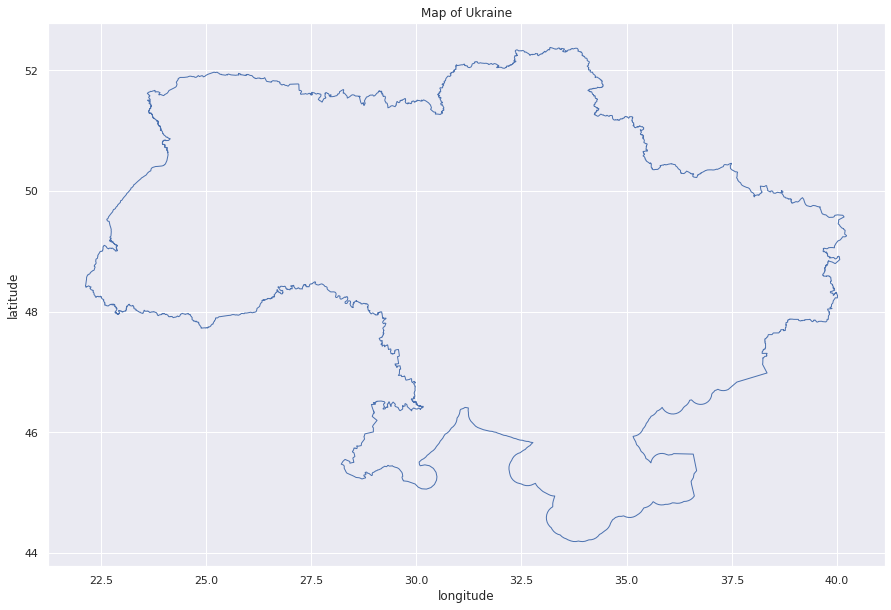

In [107]:
sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(x='longitude', y='latitude', data=coords_big_df, sort=False, lw=1).set_title("Map of Ukraine");

This map is quite detailed, so it's quite complicated to define if the point is inside the map manualy. The best solution I found is to use polygons and the [library](https://shapely.readthedocs.io/en/latest/) that works with this kind of geometrical objects. 

In [108]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

maps = Polygon(coords_big)

It works fast enough (or at least faster than a manually writen code). For example check if the point is inside the map takes no more that 40 ms for both True and False.

In [112]:
%%time
maps.contains(Point((25.,45.)))

CPU times: user 32.4 ms, sys: 1.96 ms, total: 34.4 ms
Wall time: 35.6 ms


False

In [118]:
%%time
maps.contains(Point((34.,45.)))

CPU times: user 35.5 ms, sys: 8 µs, total: 35.5 ms
Wall time: 36.3 ms


True

In [90]:
'''
function to check if the point (one of the map contour coord)
is inside the square
'''
def inside(point,coord):
  return point[0] > coord[0][0] and point[0] < coord[1][0] and point[1] > coord[0][1] and point[1] < coord[2][1]


'''
return all of the coords of the contour that fit into our square
'''
def cut_piece(coords):
  (x1,y1),(x2,y2),(x3,y3),(x4,y4) = coords
  # we can not just check if each corner of the square is inside the map because the map is not convex
  # for example if we check (30,46),(32.5,46),(30,48),(32.5,48) all corners are inside, but the figure is concave
  # so we actuale should check every point
  return [i for i in coords_big if inside(i, coords)]

For example we cut a part of Odessa to show the algorithm works.

In [143]:
%%time
piece = cut_piece([(28.,45.),(30.,45.),(28.,46.5),(30.,46.5)])

CPU times: user 137 ms, sys: 1.97 ms, total: 139 ms
Wall time: 142 ms


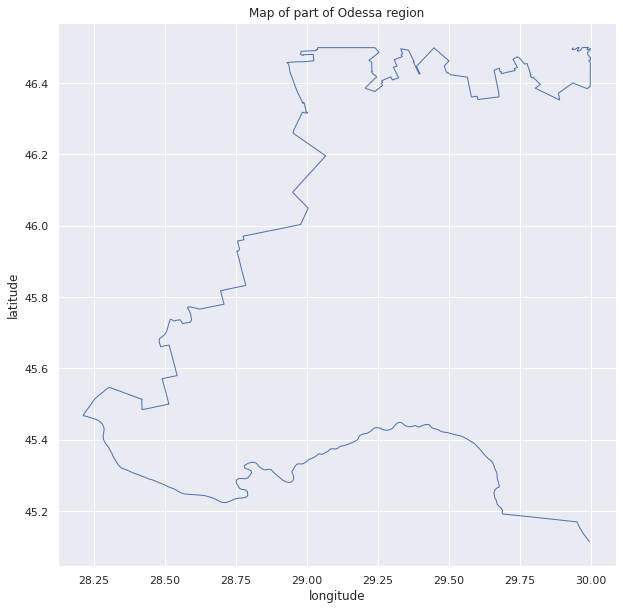

In [125]:
sns.set(rc={'figure.figsize':(10,10)})
piece_df = pd.DataFrame({'longitude': [i[0] for i in piece], 'latitude':[i[1] for i in piece]})
sns.lineplot(x ='longitude', y ='latitude', data = piece_df, sort=False, lw=1).set_title("Map of part of Odessa region");

To calculate min/max coordinates of Ukraine

In [127]:
latitude_min = min([i[1] for i in coords_big])
latitude_max = max([i[1] for i in coords_big])

longitude_min = min([i[0] for i in coords_big])
longitude_max = max([i[0] for i in coords_big])

print('Latitude: {} - {}\nLongitude: {} - {}'.format(latitude_min, latitude_max, longitude_min, longitude_max))

Latitude: 44.1845979 - 52.3797464
Longitude: 22.1370589 - 40.2275801


In general to calculate the actual length of the 1 degree on the map we need to use this formulas:
 - km_in_degree_longtitude = 111.134861111
 - km_in_degree_latitude = 111.321377778 * cos(latitude)

In [138]:
km_in_degree_longitude = 111.134861111
km_in_degree_latitude = 111.321377778

In [137]:
import math
print('The difference of the length of 1 degree: ', end = '')
print(km_in_degree_latitude*(math.cos(math.radians(latitude_min))-math.cos(math.radians(latitude_max))))

The difference of the length of 1 degree: 11.8749628443405


And as we can see for different points on the map the actual km_in_degree_latitude is almost 12 km bigger.

In [140]:
km_1_longitude = 1/km_in_degree_longitude
print(km_1_longitude)
km_1_longitude = round(km_1_longitude,3)
km_1_longitude

0.008998076661122683


0.009

To facilitate the calculations I rounded the number to 3 digits.
